In [12]:

import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [6]:
# crad = datasets.fetch_atlas_craddock_2012()
# atlas_nii = index_img(crad['scorr_mean'], i) # this needs to be modified for some tasks
# print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
# masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
# input_variables = masker.fit_transform(brain_data.gray_matter_maps)
# output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


258 regions found in this atlas


In [9]:
# train_input = input_variables[:80]
# train_output = output_variable[:80]

# print(train_input[(np.isnan(train_input) == True) | (np.isinf(train_input) == True)])

[]


In [4]:
def plot_each_n_rois(i):
  crad = datasets.fetch_atlas_craddock_2012()
  atlas_nii = index_img(crad['scorr_mean'], i) # this needs to be modified for some tasks
  print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_data().ravel())) - 1))
  masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True)
  input_variables = masker.fit_transform(brain_data.gray_matter_maps)
  output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:, 0] # gives subject age on standard units after z-scoring

  train_input = input_variables[:80]
  train_output = output_variable[:80]

  test_input = input_variables[80:]
  test_output = output_variable[80:]

  def plot_each_k_cluster(k):
    ### K-means ####
    kmeans = KMeans(n_clusters=k).fit(train_input) ### feature engineering on train_split
    kmeans_input_variables= kmeans.transform(input_variables)
    # kmeans_test_input = kmeans.transform(test_input)

    ### GMM ####
    GMM = GaussianMixture(n_components=k).fit(train_input) ### feature engineering on train_split
    gmm_input_variables = GMM.predict_proba(input_variables)
    # GMM_test_input = GMM.predict_proba(test_input)

    ### PCA ####
    pca = PCA(n_components=k).fit(train_input) ### feature engineering on train_split
    pca_input_variables = pca.transform(input_variables)
    # pca_test_input = pca.transform(test_input)

    ### ICA ####
    ica = FastICA(n_components=k).fit(train_input) ### feature engineering on train_split
    ica_input_variables = ica.transform(input_variables)
    # ica_test_input = ica.transform(test_input)

    kf = KFold(n_splits=5)

    km_accuracy = 0
    gmm_accuracy = 0
    pca_accuracy = 0
    ica_accuracy = 0
    
    km_train_accuracy = 0
    gmm_train_accuracy = 0
    pca_train_accuracy = 0
    ica_train_accuracy = 0

    for train_index, test_index in kf.split(output_variable):
      ######### KMeans #########
      kmeans_X_train, kmeans_X_test = kmeans_input_variables[train_index], kmeans_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      kmeans_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(kmeans_X_train, y_train)
      kmeans_log_predict_output = kmeans_Logmodel.predict(kmeans_X_test)
      km_accuracy += r2_score(y_test, kmeans_log_predict_output)

      kmeans_log_predict_output_tr = kmeans_Logmodel.predict(kmeans_X_train)
      km_train_accuracy += r2_score(y_train, kmeans_log_predict_output_tr)


      ######### GMM #########
      gmm_X_train, gmm_X_test = gmm_input_variables[train_index], gmm_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      gmm_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(gmm_X_train, y_train)
      gmm_log_predict_output = gmm_Logmodel.predict(gmm_X_test)
      gmm_accuracy += r2_score(y_test, gmm_log_predict_output)

      gmm_log_predict_output_tr = gmm_Logmodel.predict(gmm_X_train)
      gmm_train_accuracy += r2_score(y_train, gmm_log_predict_output_tr)

      ######### PCA #########
      pca_X_train, pca_X_test = pca_input_variables[train_index], pca_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      pca_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(pca_X_train, y_train)
      pca_log_predict_output = pca_Logmodel.predict(pca_X_test)
      pca_accuracy += r2_score(y_test, pca_log_predict_output)

      pca_log_predict_output_tr = pca_Logmodel.predict(pca_X_train)
      pca_train_accuracy += r2_score(y_train, pca_log_predict_output_tr)

      ######### ICA #########
      ica_X_train, ica_X_test = ica_input_variables[train_index], ica_input_variables[test_index]
      y_train, y_test = output_variable[train_index], output_variable[test_index]

      ica_Logmodel = KNeighborsRegressor(n_neighbors=5).fit(ica_X_train, y_train)
      ica_log_predict_output = ica_Logmodel.predict(ica_X_test)
      ica_accuracy += r2_score(y_test, ica_log_predict_output)

      ica_log_predict_output_tr = ica_Logmodel.predict(ica_X_train)
      ica_train_accuracy += r2_score(y_train, ica_log_predict_output_tr)

    return k, km_accuracy/5, gmm_accuracy/5, pca_accuracy/5, ica_accuracy/5, km_train_accuracy/5, gmm_train_accuracy/5, pca_train_accuracy/5, ica_train_accuracy/5
  
  y_list = [] ### k
  km_value_list = [] ### accuracy
  gmm_value_list = [] ### accuracy
  pca_value_list = [] ### accuracy
  ica_value_list = [] ### accuracy
  km_value_list_train = [] ### accuracy
  gmm_value_list_train = [] ### accuracy
  pca_value_list_train = [] ### accuracy
  ica_value_list_train = [] ### accuracy

  for k in range (1,11):
    k, km_accuracy, gmm_accuracy, pca_accuracy, ica_accuracy, km_train_accuracy, gmm_train_accuracy, pca_train_accuracy, ica_train_accuracy = plot_each_k_cluster(k)

    # print("i: ", i,"accuracy: ", accuracy)
    y_list.append(i)
    # log_y_list.append(log_accuracy)
    # KNN_y_list.append(KNN_accuracy)
    km_value_list.append(km_accuracy)
    gmm_value_list.append(gmm_accuracy)
    pca_value_list.append(pca_accuracy)
    ica_value_list.append(ica_accuracy)
    km_value_list_train.append(km_train_accuracy)
    gmm_value_list_train.append(gmm_train_accuracy)
    pca_value_list_train.append(pca_train_accuracy)
    ica_value_list_train.append(ica_train_accuracy)
  
  return i, km_value_list, gmm_value_list, pca_value_list, ica_value_list, km_value_list_train, gmm_value_list_train, pca_value_list_train, ica_value_list_train

In [10]:
x_list = [] ### n_rois
y_list = [1,2,3,4,5,6,7,8,9,10]
km_y_list = [] ### list of list of accuracy
gmm_y_list = [] ### list of list of accuracy
pca_y_list = [] ### list of list of accuracy
ica_y_list = [] ### list of list of accuracy
km_y_list_train = [] ### list of list of accuracy
gmm_y_list_train = [] ### list of list of accuracy
pca_y_list_train = [] ### list of list of accuracy
ica_y_list_train = [] ### list of list of accuracy

for i in range (43):
  i, km_value_list, gmm_value_list, pca_value_list, ica_value_list, km_value_list_train, gmm_value_list_train, pca_value_list_train, ica_value_list_train = plot_each_n_rois(i)

  # print("i: ", i,"accuracy: ", accuracy)
  x_list.append(i)
  # log_y_list.append(log_accuracy)
  # KNN_y_list.append(KNN_accuracy)
  km_y_list.append(km_value_list)
  gmm_y_list.append(gmm_value_list)
  pca_y_list.append(pca_value_list)
  ica_y_list.append(ica_value_list)
  km_y_list_train.append(km_value_list_train)
  gmm_y_list_train.append(gmm_value_list_train)
  pca_y_list_train.append(pca_value_list_train)
  ica_y_list_train.append(ica_value_list_train)

km_y_list = np.array(km_y_list)
gmm_y_list = np.array(gmm_y_list)
pca_y_list = np.array(pca_y_list)
ica_y_list = np.array(ica_y_list)
km_y_list_train = np.array(km_y_list_train)
gmm_y_list_train = np.array(gmm_y_list_train)
pca_y_list_train = np.array(pca_y_list_train)
ica_y_list_train = np.array(ica_y_list_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


10 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

20 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

30 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


40 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


50 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


60 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


70 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


80 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

90 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


99 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

106 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


119 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

128 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

138 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

147 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

157 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tole

169 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


176 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

185 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

195 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


205 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


210 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


220 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

225 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

233 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

249 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

258 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

265 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

271 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

274 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

319 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

356 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

396 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a mo

439 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


467 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


507 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


552 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


586 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

623 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


666 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of v

707 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


740 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


788 regions found in this atlas


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [20]:
km_y_list = np.transpose(km_y_list)
gmm_y_list = np.transpose(gmm_y_list)
pca_y_list = np.transpose(pca_y_list)
ica_y_list = np.transpose(ica_y_list)
km_y_list_train = np.transpose(km_y_list_train)
gmm_y_list_train = np.transpose(gmm_y_list_train)
pca_y_list_train = np.transpose(pca_y_list_train)
ica_y_list_train = np.transpose(ica_y_list_train)

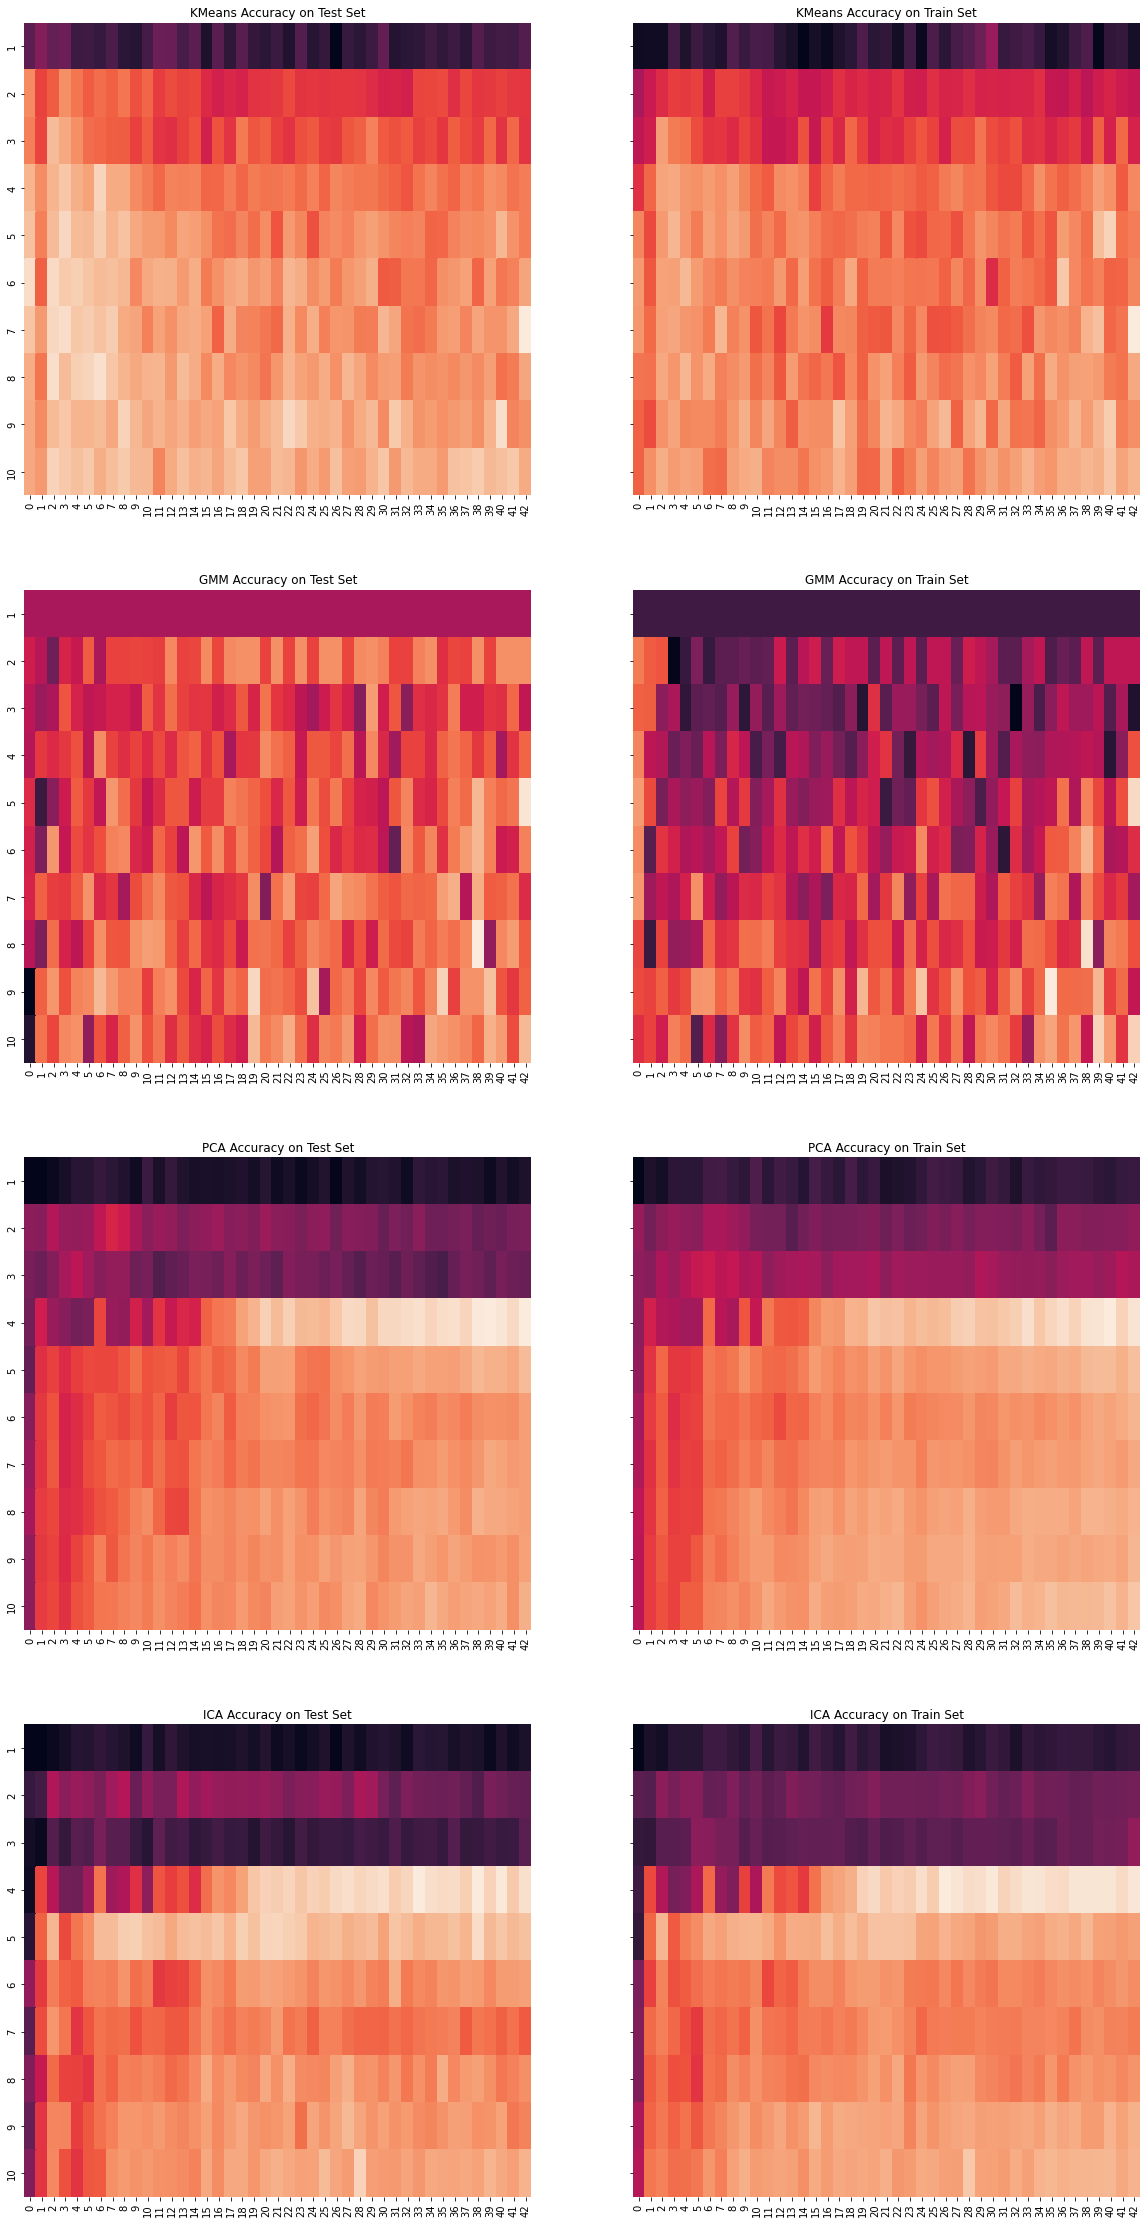

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(20, 40), sharey=True)

ax_km_y_list = sns.heatmap(km_y_list,xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,0])
ax_gmm_y_list = sns.heatmap(gmm_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,0])
ax_pca_y_list = sns.heatmap(pca_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[2,0])
ax_ica_y_list = sns.heatmap(ica_y_list, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[3,0])
ax_km_y_list_train = sns.heatmap(km_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[0,1])
ax_gmm_y_list_train = sns.heatmap(gmm_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[1,1])
ax_pca_y_list_train = sns.heatmap(pca_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[2,1])
ax_ica_y_list_train = sns.heatmap(ica_y_list_train, xticklabels=x_list, yticklabels=y_list,cbar=False,ax=axes[3,1])

ax_km_y_list.set_title('KMeans Accuracy on Test Set')
ax_gmm_y_list.set_title('GMM Accuracy on Test Set')
ax_pca_y_list.set_title('PCA Accuracy on Test Set')
ax_ica_y_list.set_title('ICA Accuracy on Test Set')
ax_km_y_list_train.set_title('KMeans Accuracy on Train Set')
ax_gmm_y_list_train.set_title('GMM Accuracy on Train Set')
ax_pca_y_list_train.set_title('PCA Accuracy on Train Set')
ax_ica_y_list_train.set_title('ICA Accuracy on Train Set')
plt.show()